# sumaryzacja tekstu

In [1]:
from google.colab import drive


drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [2]:
!nvidia-smi

Sun Feb  1 11:08:17 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   58C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
!pip install "datasets<3.0.0" #przy nowszych wersjach biblioteki datasets występowały problemy z pobraniem zbioru xsum


  Using cached datasets-2.21.0-py3-none-any.whl.metadata (21 kB)
Using cached datasets-2.21.0-py3-none-any.whl (527 kB)
  Attempting uninstall: datasets
    Found existing installation: datasets 4.3.0
    Uninstalling datasets-4.3.0:
      Successfully uninstalled datasets-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
unsloth-zoo 2026.1.4 requires datasets!=4.0.*,!=4.1.0,<4.4.0,>=3.4.1, but you have datasets 2.21.0 which is incompatible.
trl 0.24.0 requires datasets>=3.0.0, but you have datasets 2.21.0 which is incompatible.


In [4]:
!pip install bert-extractive-summarizer

In [5]:
!pip install pytorch-ignite

## importowanie datesetu

In [6]:
from datasets import load_dataset


ds = load_dataset("EdinburghNLP/xsum", trust_remote_code=True)
ds= ds.filter(lambda example: len(example["document"]) < 1500)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [7]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 84554
    })
    validation: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4705
    })
    test: Dataset({
        features: ['document', 'summary', 'id'],
        num_rows: 4689
    })
})
Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 2
})


In [8]:
from summarizer import Summarizer
model_bertsum = Summarizer()

In [9]:
from ignite.metrics import Rouge

{'Rouge-L-P': 0.6, 'Rouge-L-R': 0.5, 'Rouge-L-F': 0.5, 'Rouge-1-P': 0.8, 'Rouge-1-R': 0.5714285714285714, 'Rouge-1-F': 0.5714285714285714}


In [10]:
num_workers = 1
batch_size = 1

In [11]:
from torch.utils.data import DataLoader
import torch
test_dataset = ds["test"].select(range(500))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
print(test_dataset)


Dataset({
    features: ['document', 'summary', 'id'],
    num_rows: 500
})


In [12]:
import random
random_index = random.randint(0, len(ds["test"]) - 1)
showcase_dataset = ds["test"].select([random_index])
showcase_loader = DataLoader(showcase_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
batch = next(iter(showcase_loader))
print(f"Document: {batch['document'][0]}")
print(f"Target: {batch['summary'][0]}")

Document: The hurlers of Ruairí Óg Cushendall have been backed to "bring home" an All-Ireland title by Hollywood hero Liam Neeson.
The club, based in Neeson's native County Antrim, will take on Na Piarsaigh of County Limerick in the senior club final in Dublin on St Patrick's Day.
The Taken star won a schools' hurling crown with St Patrick's College in his hometown Ballymena back in 1966.
And he proved he hasn't lost his touch in the short video clip, catching a sliotar, the small leather ball used in the game, before sending it into the distance as he roared on the Ruairís.
The All-Ireland club hurling final will be live on the BBC Sport website and BBC Radio Ulster 1341MW from 13:30 GMT on Thursday 17 March.
Target: It is a sight that would surely strike fear into even the most battle-hardened opponent.


In [13]:
import string


def clean(text):
    if not text:
        return ["."]
    text = text.lower().translate(
        str.maketrans(string.punctuation, " " * len(string.punctuation))
    )
    return text.split()


def rouge_score_loss(
    batch,
    model,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
    m=Rouge(variants=["L", 2], multiref="best"),
    prints = False,
    chat = False
):
    if bert:
        predictions = [
            model(doc, ratio=0.1) for doc in batch["document"]
        ]
    else:
        docs = [doc for doc in batch["document"]]

        prompted = [
            f"{prompt}{doc}{promptsuff}" for doc in batch["document"]
        ]
        if chat:
          prompted = [
            {"role": "user", "content": f"{prompt} {doc}"} for doc in batch["document"]
          ]

          text = tokenizer.apply_chat_template(
              prompted,
              tokenize=False,
              add_generation_prompt=True
          )
          inputs = tokenizer([text], return_tensors="pt").to(model.device)
        else:
          inputs = tokenizer(
              prompted,
              return_tensors="pt",
              padding=True,
              truncation=True,
              max_length=4096,
          )

        device = next(model.parameters()).device
        inputs = {k: v.to(device) for k, v in inputs.items()}

        summary_ids = model.generate(
            inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_new_tokens=50,
            do_sample=True,
            top_k=0,
            temperature=0.5,
        )

        input_length = inputs["input_ids"].shape[1]
        new_tokens = summary_ids[:, input_length:]

        predictions = tokenizer.batch_decode(
            new_tokens, skip_special_tokens=True
        )

    if prints:
      print(f"Prediction: {predictions[0]}")
    predictions = [
        clean(pred) if pred.strip() else "." for pred in predictions
    ]

    targets = [[clean(ref)] for ref in batch["summary"]]
    m.update((predictions, targets))
    return m.compute()

In [55]:
from matplotlib import pyplot as plt
import numpy as np

def plot_data(data, labels=['Rouge-1-P', 'Rouge-1-R', 'Rouge-1-F','Rouge-2-P', 'Rouge-2-R', 'Rouge-2-F',  'Rouge-L-P', 'Rouge-L-R', 'Rouge-L-F', ], models = ['Qwen 1.5 0.5B - LoRa', 'Qwen 1.5 0.5B - few shot 1', 'Qwen 1.5 0.5B - few shot 3', 'Qwen 1.5 0.5B - zero shot','Qwen 1.5 0.5B - chat', 'Bertsum - bert-base-uncased', 'Bertsum - Sbertmodel', 'Bertsum - roberta-base','Qwen 2.5 3B - zero shot', 'Qwen 2.5 3B - few shot 1',  'Qwen 2.5 3B - few shot 3', 'Qwen 2.5 3B - instruct'], width = 0.075, size=45):
    x = np.arange(len(labels))

    plt.figure(figsize=(size, 12))
    for i, row in enumerate(data):
        offset = x + (i * width)
        plt.bar(offset, row, width=width, label=models[i])
    center_offset = ((len(data) - 1) * width) / 2
    plt.xticks(x + center_offset, labels)

    plt.ylim(0, 1)
    plt.ylabel('Score')
    plt.title('ROUGE Score Comparison')
    plt.legend()
    plt.show()

In [15]:
def batch_to_device(batch: dict, device) -> dict:
    return {k: v.to(device) for k, v in batch.items()}

In [16]:
import torch
import torch.nn as nn
from torch import Tensor
def calc_loss_batch(batch: dict, model: nn.Module) -> Tensor:
    logits = model(batch['input_ids'])
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), batch['labels'].flatten())
    return loss

In [17]:
import numpy as np
from tqdm.notebook import tqdm
def calc_loss_loader(
    data_loader,
    model,
    device,
    bert: bool,
    tokenizer: any,
    prompt=None,
    promptsuff=None,
    prints = False,
    chat=False
) -> float:
    results = []
    loader_bar = tqdm(data_loader, desc="Calculating ROUGE average score", leave=False)
    for i, batch in enumerate(loader_bar):

        m = Rouge(variants=[1,2,"L"], multiref="best")

        ret = rouge_score_loss(
            batch,
            model,
            bert,
            tokenizer,
            prompt,
            promptsuff,
            m,
            prints,
            chat,
        )
        results.append(list(ret.values()))

    results = np.array(results)
    return np.mean(results, axis=0)


In [18]:
def evaluate_model(
    model: nn.Module,
    loader: DataLoader,
    device,
    bert: bool,
    tokenizer: any,
    prompt: str = "",
    promptsuff: str = "",
    prints = False,
    chat = False
) -> tuple[float, float]:
    if not bert:
        model.eval()

    with torch.no_grad():
        loss = calc_loss_loader(
            loader,
            model,
            device,
            bert=bert,
            tokenizer=tokenizer,
            prompt=prompt,
            promptsuff=promptsuff,
            prints=prints,
            chat=chat
        )

    return loss




In [19]:
from torch import nn
data_bertsum = evaluate_model(model_bertsum, test_loader, device='cuda', bert=True, tokenizer=None)



Calculating ROUGE average score:   0%|          | 0/500 [00:00<?, ?it/s]

In [20]:
from summarizer.sbert import SBertSummarizer
model_sbert = SBertSummarizer('paraphrase-MiniLM-L6-v2')
data_bertsum_sbert = evaluate_model(model_sbert, test_loader, device='cuda', bert=True, tokenizer=None)

Calculating ROUGE average score:   0%|          | 0/500 [00:00<?, ?it/s]

In [21]:
from summarizer import TransformerSummarizer
model_roberta = TransformerSummarizer(transformer_type="Roberta", transformer_model_key="roberta-base")
data_bertsum_roberta = evaluate_model(model_roberta, test_loader, device='cuda', bert=True, tokenizer=None)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Calculating ROUGE average score:   0%|          | 0/500 [00:00<?, ?it/s]

In [22]:
def generate_prompt(tokenizer, size):
    prompt = ""
    shots = ds["train"].train_test_split(train_size=size, seed=35)["train"]
    shots_loader = DataLoader(shots, batch_size=100000, shuffle=True, num_workers=num_workers)
    for batch in shots_loader:
        for i in range(len(batch['document'])):
            prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer."
            prompt += f'[TEXT]{batch['document'][i]}[AGENT]{batch['summary'][i]}'
            prompt += tokenizer.eos_token + "\n"
    prompt += "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
    return prompt


In [23]:
!pip uninstall -y unsloth unsloth_zoo

# 2. Install Unsloth Zoo DIRECTLY from Git (to get 'tiled_mlp')
!pip install --upgrade --no-cache-dir "unsloth_zoo @ git+https://github.com/unslothai/unsloth-zoo.git"

# 3. Install Unsloth main library from Git
!pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

Found existing installation: unsloth 2026.1.4
Uninstalling unsloth-2026.1.4:
  Successfully uninstalled unsloth-2026.1.4
Found existing installation: unsloth_zoo 2026.1.4
Uninstalling unsloth_zoo-2026.1.4:
  Successfully uninstalled unsloth_zoo-2026.1.4
  Cloning https://github.com/unslothai/unsloth-zoo.git to /tmp/pip-install-hfw657jv/unsloth-zoo_6d24d44ee4ce453bb7fb49018ef5682d
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth-zoo.git /tmp/pip-install-hfw657jv/unsloth-zoo_6d24d44ee4ce453bb7fb49018ef5682d
  Resolved https://github.com/unslothai/unsloth-zoo.git to commit 2a80d543b9e22f68e051e32029c8a47005102895
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 26.7 MB/s eta 0:00:00
  Created wheel for unsloth_zoo: filename=unsloth_zoo-2026.1.4-py3-none-any.whl size=310708 sha256=4b13901b9a51f43ccd96c982

  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-g4x8q1gd/unsloth_fe63450323684e6d9f709dcb024f2f55
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-g4x8q1gd/unsloth_fe63450323684e6d9f709dcb024f2f55
  Resolved https://github.com/unslothai/unsloth.git to commit 07a7ff47b1b2b37c088b8e0d7ed7bf8710d9aa22
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2026.1.4-py3-none-any.whl size=412718 sha256=8d39358193080c86038a4659e4ca167584838e1678d249dff5c9cddafee5d9a0
  Stored in directory: /tmp/pip-ephem-wheel-cache-2cgw_4ml/wheels/60/3e/1f/e576c07051d90cf64b6a41434d87ccf4db33fafd5343bf5de0
Successfully built unsloth


In [24]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from unsloth import FastLanguageModel



/tmp/ipython-input-1311217971.py:2: UserWarning: WARNING: Unsloth should be imported before [transformers, peft] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [25]:
import gc
try:
  del model
  del tokenizer3
  del model
except NameError:
  pass

gc.collect()

60

In [26]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen1.5-0.5B", max_seq_length=32000, load_in_4bit=False
)
prompt1 = generate_prompt(tokenizer, 1)
print(prompt1)
torch.cuda.empty_cache()
data_1 = evaluate_model(model, test_loader, device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt1, promptsuff = "[AGENT]")

==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Qwen/Qwen1.5-0.5B does not have a padding token! Will use pad_token = <|PAD_TOKEN|>.
[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]The 28-year-old and rowing partner Grainger, a 2012 gold medallist, compete in the women's double sculls heats at the European Championships.
Thornley, from Wrexham, is confident of securing a place at Rio.
"With it being Katherine's fifth Olympics there's no-one else you'd want sat behind you," she said.
"She knows how to handle pressure so well.
Media playback

Calculating ROUGE average score:   0%|          | 0/500 [00:00<?, ?it/s]

In [27]:

prompt3 = generate_prompt(tokenizer, 3)
torch.cuda.empty_cache()
data_3 = evaluate_model(model, test_loader, device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt3, promptsuff = "[AGENT]")

Calculating ROUGE average score:   0%|          | 0/500 [00:00<?, ?it/s]

In [28]:
prompt0 = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]"
data_zero_shot = evaluate_model(
        model,
        test_loader,
        device="cuda",
        bert=False,
        tokenizer=tokenizer,
        prompt=prompt0,
        promptsuff = "[AGENT]"
    )


Calculating ROUGE average score:   0%|          | 0/500 [00:00<?, ?it/s]

In [29]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
from peft import PeftModel
model_path = './drive/MyDrive/models/ft'
ft_model = PeftModel.from_pretrained(model, model_path, max_sequence_length=32000, load_in_4bit=False)


In [31]:
data_ft = evaluate_model(ft_model, test_loader, 'cuda', bert=False, tokenizer = tokenizer, prompt = "[USER] Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer.[TEXT]", promptsuff = "[AGENT]")

Calculating ROUGE average score:   0%|          | 0/500 [00:00<?, ?it/s]

In [32]:
prompt_instruct = "Summarize this text. Don't hallucinate. Be thorough and explicit. Always provide an anwer."
model15_instruct, tokenizer_instruct_15 = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen1.5-0.5B-chat", max_seq_length=32000, load_in_4bit=False
)
data_instruct_15 = evaluate_model(model15_instruct, test_loader, device='cuda', bert=False, tokenizer=tokenizer_instruct_15, prompt=prompt_instruct, promptsuff = "[AGENT]", chat=True)

==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Calculating ROUGE average score:   0%|          | 0/500 [00:00<?, ?it/s]

In [33]:
print(f"Document: {batch['document'][0]}")
print(f"Target: {batch['summary'][0]}")
print('Bertsum - bert-base-uncased')
evaluate_model(model_bertsum, showcase_loader, device='cuda', bert=True, tokenizer=None, prints = True)
print('Bertsum - Sbertmodel')
evaluate_model(model_sbert, showcase_loader, device='cuda', bert=True, tokenizer=None, prints = True)
print('Bertsum - roberta-base')
evaluate_model(model_roberta, showcase_loader, device='cuda', bert=True, tokenizer=None, prints = True)
print("Qwuen 1.5 0.5B zero shot:")
evaluate_model(model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt0, promptsuff = "[AGENT]", prints = True)
print("Qwuen 1.5 0.5B one shot:")
evaluate_model(model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt1, promptsuff = "[AGENT]", prints = True)
print("Qwuen 1.5 0.5B three shot:")
evaluate_model(model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt3, promptsuff = "[AGENT]", prints = True)
print("Qwuen 1.5 0.5B fine tuned:")
evaluate_model(ft_model, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer, prompt=prompt0, promptsuff = "[AGENT]", prints = True)
print("Qwuen 1.5 0.5B chat:")
evaluate_model(model15_instruct, showcase_loader, device='cuda', bert=False, tokenizer=tokenizer_instruct_15, prompt=prompt_instruct, prints = True,chat=True)


Document: The hurlers of Ruairí Óg Cushendall have been backed to "bring home" an All-Ireland title by Hollywood hero Liam Neeson.
The club, based in Neeson's native County Antrim, will take on Na Piarsaigh of County Limerick in the senior club final in Dublin on St Patrick's Day.
The Taken star won a schools' hurling crown with St Patrick's College in his hometown Ballymena back in 1966.
And he proved he hasn't lost his touch in the short video clip, catching a sliotar, the small leather ball used in the game, before sending it into the distance as he roared on the Ruairís.
The All-Ireland club hurling final will be live on the BBC Sport website and BBC Radio Ulster 1341MW from 13:30 GMT on Thursday 17 March.
Target: It is a sight that would surely strike fear into even the most battle-hardened opponent.
Bertsum - bert-base-uncased


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: The hurlers of Ruairí Óg Cushendall have been backed to "bring home" an All-Ireland title by Hollywood hero Liam Neeson. The club, based in Neeson's native County Antrim, will take on Na Piarsaigh of County Limerick in the senior club final in Dublin on St Patrick's Day.
Bertsum - Sbertmodel


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: The hurlers of Ruairí Óg Cushendall have been backed to "bring home" an All-Ireland title by Hollywood hero Liam Neeson. The Taken star won a schools' hurling crown with St Patrick's College in his hometown Ballymena back in 1966.
Bertsum - roberta-base


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: The hurlers of Ruairí Óg Cushendall have been backed to "bring home" an All-Ireland title by Hollywood hero Liam Neeson. The Taken star won a schools' hurling crown with St Patrick's College in his hometown Ballymena back in 1966.
Qwuen 1.5 0.5B zero shot:


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: The Donegal club Ruairí Óg Cushendall have been chosen as the champions of the All-Ireland senior hurling championship. The club in Dublin will play Na Piarsaigh of County Limerick in the final in Dublin
Qwuen 1.5 0.5B one shot:


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: The Donegal club hurlers are set to face the Westmeath champions at the All-Ireland hurling final in Dublin on Sunday. The final is to take place at 19:30 BST on Saturday, 17 March.
Qwuen 1.5 0.5B three shot:


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: The Ruairí Óg Cushendall hurlers have been named in the All-Ireland senior hurling final at the GAA Championship final at the Aviva Stadium in Dublin on 19 March. The final is set to be shown
Qwuen 1.5 0.5B fine tuned:


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: The Ruairí Óg Cushendall club has been chosen to play in the All-Ireland club hurling final at the 2016 All-Ireland Championship. The club in Dublin is making its first appearance in the final since
Qwuen 1.5 0.5B chat:


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: The hurlers of Ruairí Óg Cushendall have been backed to bring home the All-Ireland title by Hollywood legend Liam Neeson. The club, based in Neeson's native County Antrim, will take on Na Piars


array([0.02857143, 0.0625    , 0.0625    , 0.        , 0.        ,
       0.        , 0.02857143, 0.0625    , 0.0625    ])

In [34]:
del model_bertsum, model_sbert, model_roberta,model, ft_model, model15_instruct
gc.collect()

38571

In [35]:
model25_instruct, tokenizer_instruct_25 = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-3B-instruct", max_seq_length=32000, load_in_4bit=False
)
data_instruct_25 = evaluate_model(model25_instruct, test_loader, device='cuda', bert=False, tokenizer=tokenizer_instruct_25, prompt=prompt_instruct, promptsuff = "[AGENT]", chat=True)

==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating ROUGE average score:   0%|          | 0/500 [00:00<?, ?it/s]

In [37]:
print(f"Document: {batch['document'][0]}")
print(f"Target: {batch['summary'][0]}")
print("Qwuen 2.5 3B instruct:")
evaluate_model(model25_instruct, showcase_loader, device='cuda', bert=False, tokenizer=tokenizer_instruct_25, prompt=prompt_instruct, prints=True,chat=True)


Document: The hurlers of Ruairí Óg Cushendall have been backed to "bring home" an All-Ireland title by Hollywood hero Liam Neeson.
The club, based in Neeson's native County Antrim, will take on Na Piarsaigh of County Limerick in the senior club final in Dublin on St Patrick's Day.
The Taken star won a schools' hurling crown with St Patrick's College in his hometown Ballymena back in 1966.
And he proved he hasn't lost his touch in the short video clip, catching a sliotar, the small leather ball used in the game, before sending it into the distance as he roared on the Ruairís.
The All-Ireland club hurling final will be live on the BBC Sport website and BBC Radio Ulster 1341MW from 13:30 GMT on Thursday 17 March.
Target: It is a sight that would surely strike fear into even the most battle-hardened opponent.
Qwuen 2.5 3B instruct:


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: Hollywood actor Liam Neeson has publicly supported Ruairí Og Cushendall, a hurling club based in County Antrim, by predicting they will win the All-Ireland Senior Club Championship. This championship match is set to take place on St


array([0.07894737, 0.1875    , 0.1875    , 0.        , 0.        ,
       0.        , 0.05263158, 0.125     , 0.125     ])

In [38]:
del model25_instruct
gc.collect()

62

In [39]:

model_better, tokenizer_better = FastLanguageModel.from_pretrained(
    model_name="Qwen/Qwen2.5-3B", max_seq_length=32000, load_in_4bit=False
)
data_better = evaluate_model(model_better, test_loader, device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt0, promptsuff = "[AGENT]")

==((====))==  Unsloth 2026.1.4: Fast Qwen2 patching. Transformers: 4.57.6.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Calculating ROUGE average score:   0%|          | 0/500 [00:00<?, ?it/s]

In [40]:
prompt1_better = generate_prompt(tokenizer_better, 1)
data_better_1 = evaluate_model(model_better, test_loader, device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt1_better, promptsuff = "[AGENT]")

Calculating ROUGE average score:   0%|          | 0/500 [00:00<?, ?it/s]

In [41]:
prompt3_better = generate_prompt(tokenizer_better, 3)
data_better_3 = evaluate_model(model_better, test_loader, device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt3_better, promptsuff = "[AGENT]")

Calculating ROUGE average score:   0%|          | 0/500 [00:00<?, ?it/s]

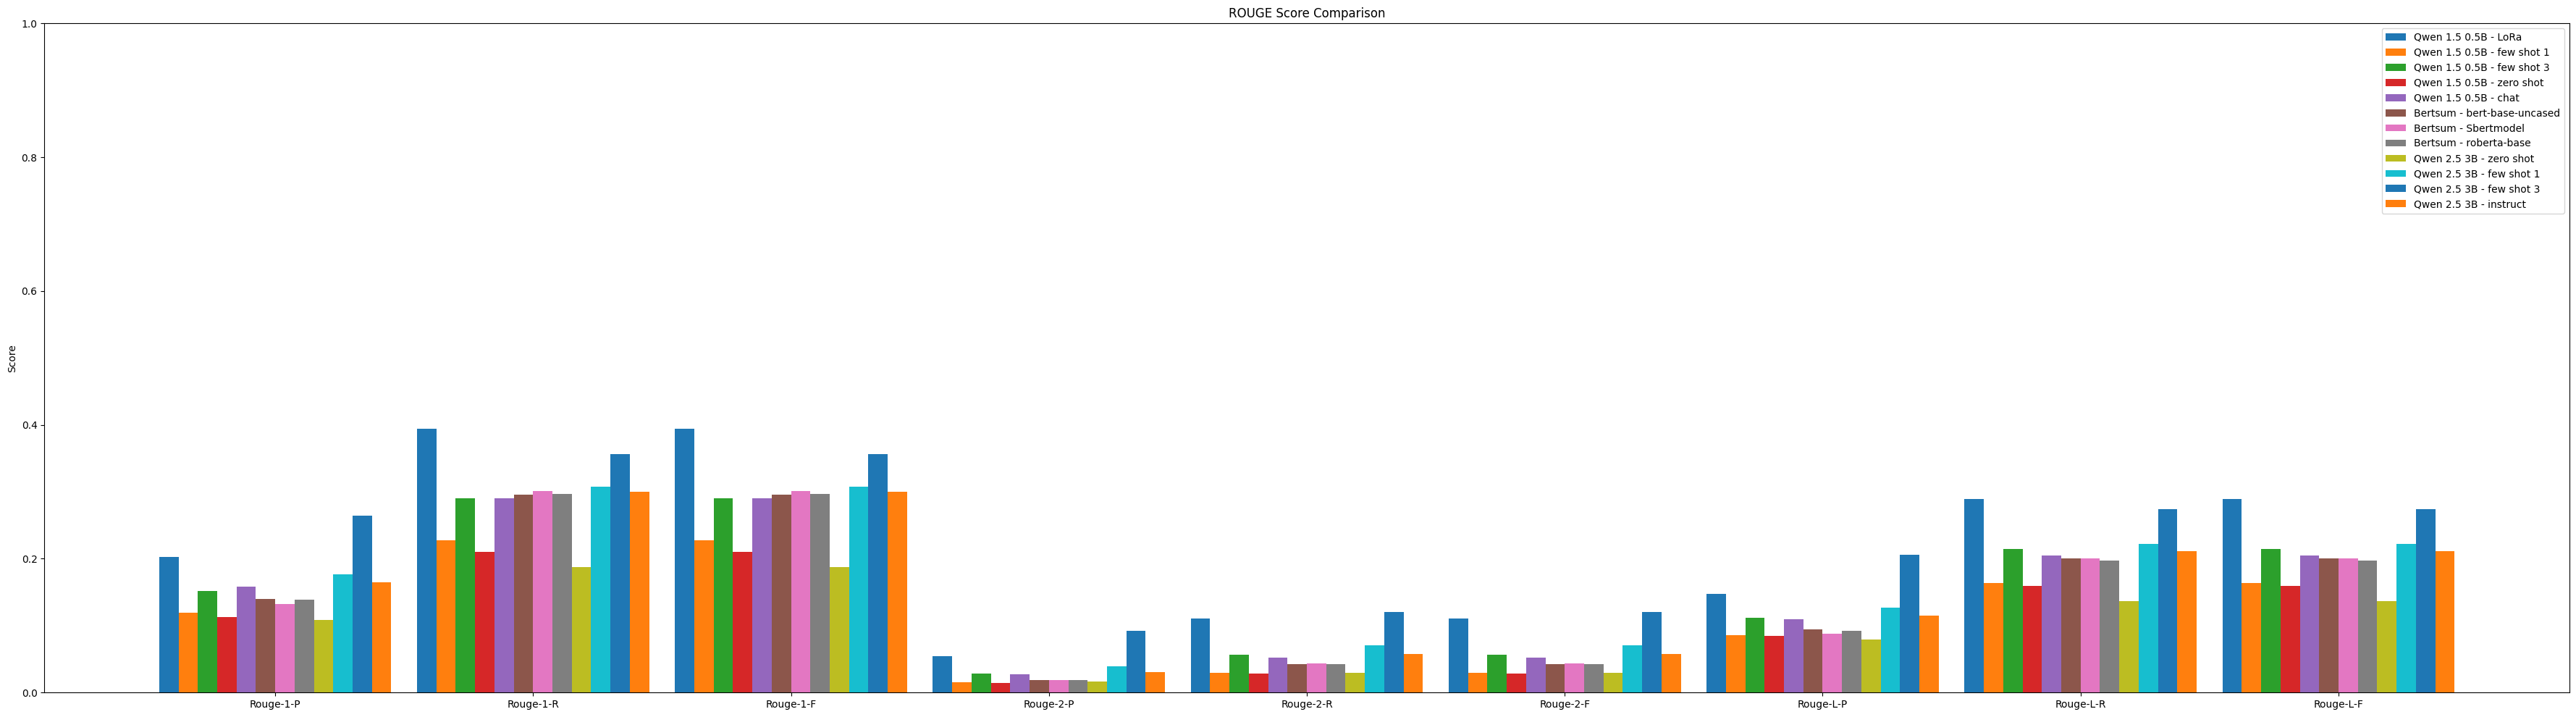

In [42]:
plot_data([data_ft, data_1,data_3, data_zero_shot,data_instruct_15, data_bertsum, data_bertsum_sbert,data_bertsum_roberta, data_better, data_better_1, data_better_3, data_instruct_25])


In [43]:
print(f"Document: {batch['document'][0]}")
print(f"Target: {batch['summary'][0]}")
print("Qwuen 2.5 3B zero shot:")
evaluate_model(model_better, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt0, promptsuff = "[AGENT]", prints = True)
print("Qwuen 2.5 3B one shot:")
evaluate_model(model_better, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt1_better, promptsuff = "[AGENT]", prints = True)
print("Qwuen 2.5 3B three shot:")
evaluate_model(model_better, showcase_loader , device='cuda', bert=False, tokenizer=tokenizer_better, prompt=prompt3_better, promptsuff = "[AGENT]", prints = True)


Document: The hurlers of Ruairí Óg Cushendall have been backed to "bring home" an All-Ireland title by Hollywood hero Liam Neeson.
The club, based in Neeson's native County Antrim, will take on Na Piarsaigh of County Limerick in the senior club final in Dublin on St Patrick's Day.
The Taken star won a schools' hurling crown with St Patrick's College in his hometown Ballymena back in 1966.
And he proved he hasn't lost his touch in the short video clip, catching a sliotar, the small leather ball used in the game, before sending it into the distance as he roared on the Ruairís.
The All-Ireland club hurling final will be live on the BBC Sport website and BBC Radio Ulster 1341MW from 13:30 GMT on Thursday 17 March.
Target: It is a sight that would surely strike fear into even the most battle-hardened opponent.
Qwuen 2.5 3B zero shot:


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction:  Liam Neeson
Qwuen 2.5 3B one shot:


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: Liam Neeson has backed his native County Antrim hurling club Ruairí Óg Cushendall to win the All-Ireland senior club title. The actor, who won a schools' hurling crown with St Patrick's College in
Qwuen 2.5 3B three shot:


Calculating ROUGE average score:   0%|          | 0/1 [00:00<?, ?it/s]

Prediction: Hurling club Ruairí Óg Cushendall have been backed by Hollywood star Liam Neeson to win the All-Ireland senior club title. The video clip shows the actor catching a sliotar and firing it into the distance


array([0.11111111, 0.25      , 0.25      , 0.        , 0.        ,
       0.        , 0.08333333, 0.1875    , 0.1875    ])

In [49]:
print(f"Document: {batch['document'][0]}")
print(f"Target: {batch['summary'][0]}")
data_qwen15 = np.array([data_zero_shot, data_1, data_3, data_ft, data_instruct_15])
data_bertsums = np.array([data_bertsum, data_bertsum_sbert, data_bertsum_roberta])
data_qwen25 = np.array([data_better, data_better_1, data_better_3, data_instruct_25 ])

print(data_qwen15)

Document: The hurlers of Ruairí Óg Cushendall have been backed to "bring home" an All-Ireland title by Hollywood hero Liam Neeson.
The club, based in Neeson's native County Antrim, will take on Na Piarsaigh of County Limerick in the senior club final in Dublin on St Patrick's Day.
The Taken star won a schools' hurling crown with St Patrick's College in his hometown Ballymena back in 1966.
And he proved he hasn't lost his touch in the short video clip, catching a sliotar, the small leather ball used in the game, before sending it into the distance as he roared on the Ruairís.
The All-Ireland club hurling final will be live on the BBC Sport website and BBC Radio Ulster 1341MW from 13:30 GMT on Thursday 17 March.
Target: It is a sight that would surely strike fear into even the most battle-hardened opponent.
[[0.11255322 0.20975018 0.20975018 0.01477195 0.02793294 0.02793294
  0.08438497 0.15900068 0.15900068]
 [0.11965933 0.22738326 0.22738326 0.01519661 0.02998107 0.02998107
  0.0853262

In [50]:
print(data_bertsums)

[[0.13957587 0.29576182 0.29576182 0.01905831 0.04240072 0.04240072
  0.09403382 0.20086427 0.20086427]
 [0.13255808 0.3012146  0.3012146  0.01852795 0.04360285 0.04360285
  0.08809197 0.20077871 0.20077871]
 [0.13915214 0.29631786 0.29631786 0.01920006 0.04256269 0.04256269
  0.09192517 0.19701945 0.19701945]]


In [51]:
print(data_qwen25)

[[0.10859905 0.18752616 0.18752616 0.01702724 0.02962564 0.02962564
  0.07951996 0.13675205 0.13675205]
 [0.17648646 0.30764934 0.30764934 0.0387436  0.0701109  0.0701109
  0.12659756 0.22191939 0.22191939]
 [0.264534   0.35609234 0.35609234 0.09259052 0.12037858 0.12037858
  0.20543476 0.27393608 0.27393608]
 [0.16457025 0.30040341 0.30040341 0.03068294 0.05796611 0.05796611
  0.11543387 0.21186403 0.21186403]]


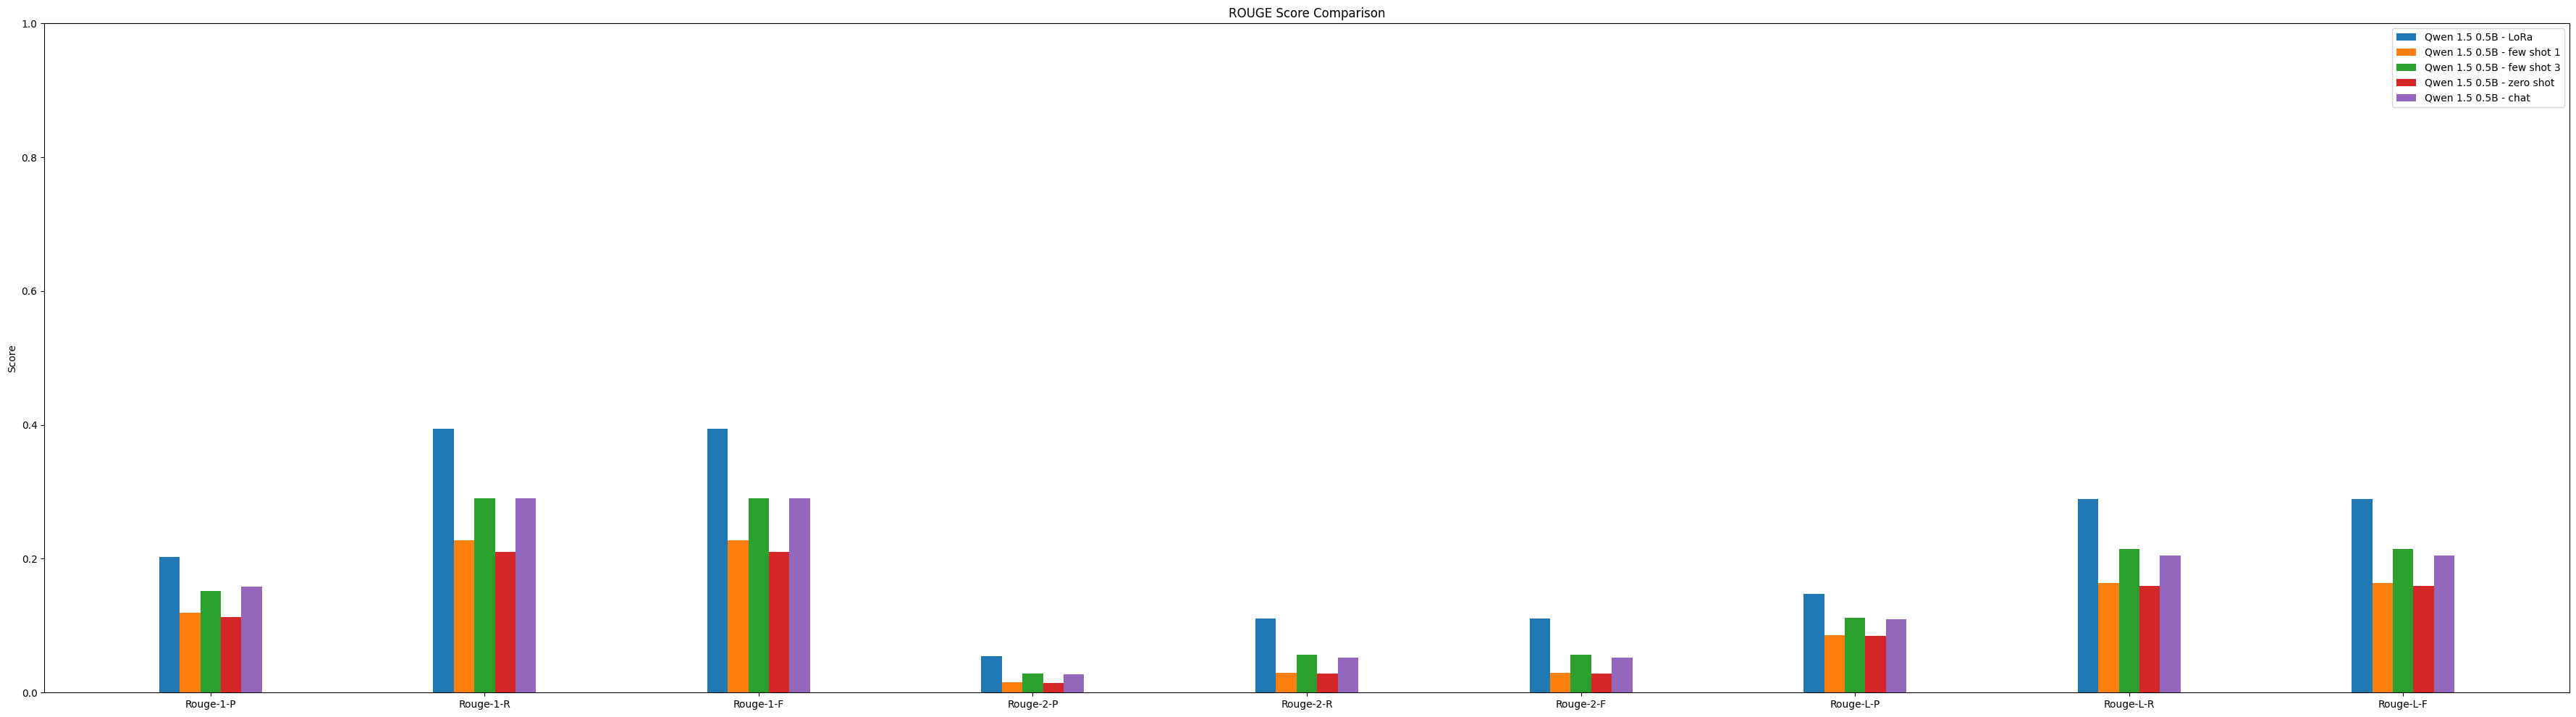

In [52]:

plot_data([data_ft, data_1,data_3, data_zero_shot,data_instruct_15], models=['Qwen 1.5 0.5B - LoRa', 'Qwen 1.5 0.5B - few shot 1', 'Qwen 1.5 0.5B - few shot 3', 'Qwen 1.5 0.5B - zero shot','Qwen 1.5 0.5B - chat'],width = 0.15, size = 20)


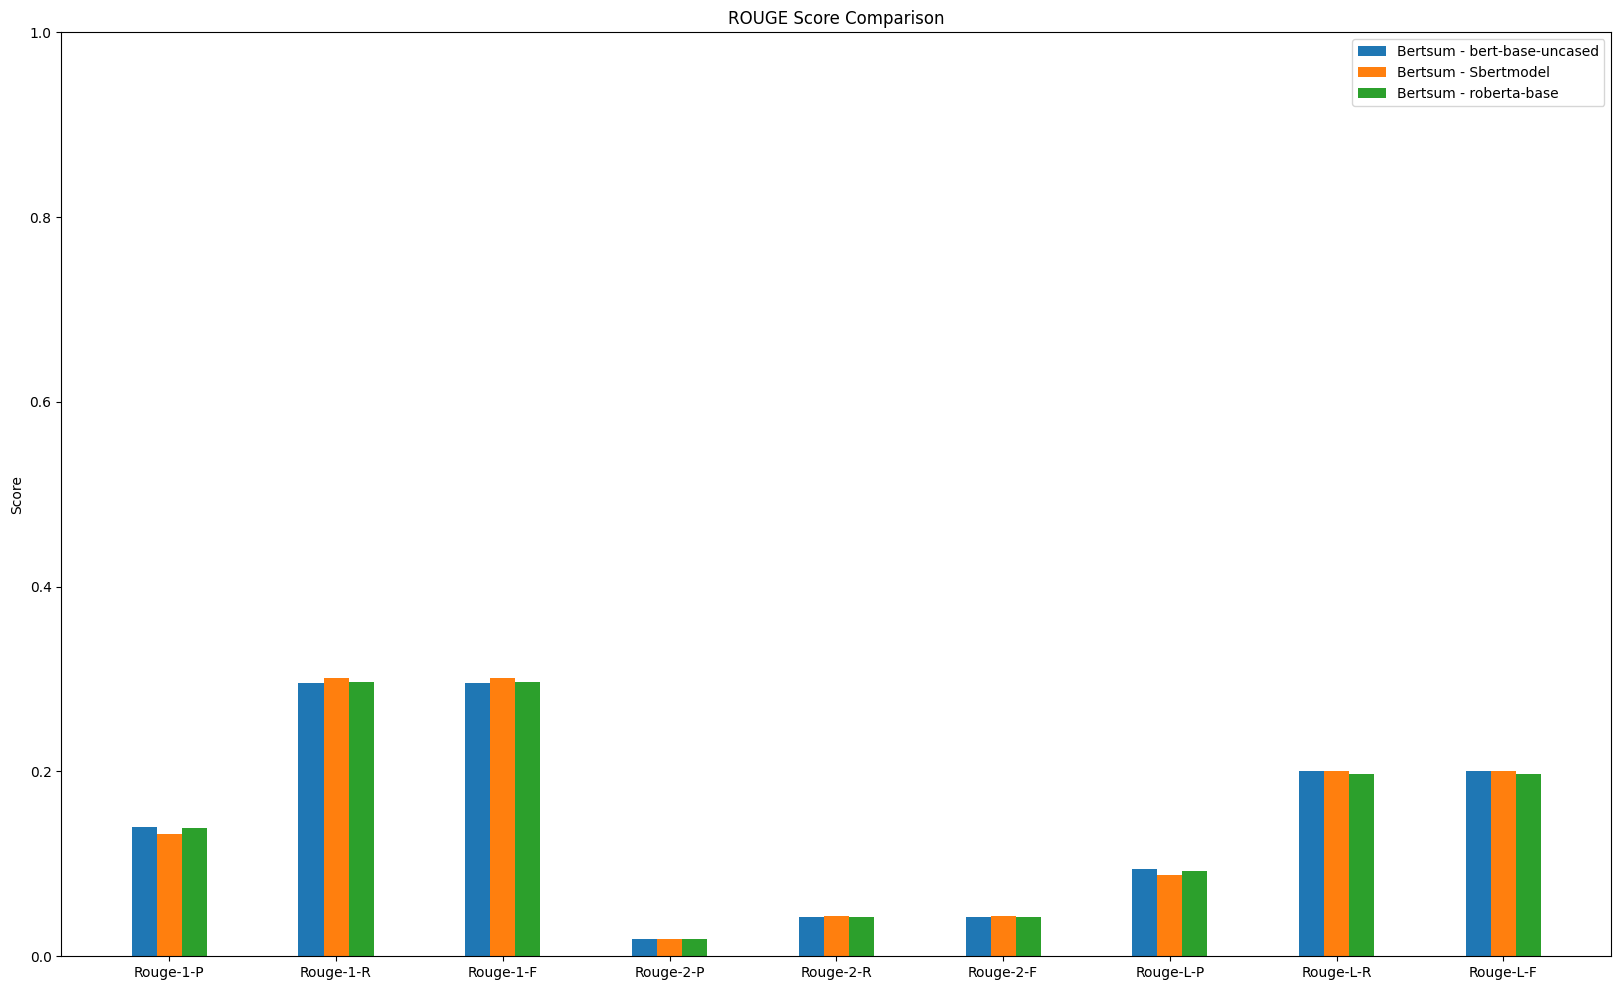

In [68]:
plot_data([data_bertsum, data_bertsum_sbert,data_bertsum_roberta], models= ['Bertsum - bert-base-uncased', 'Bertsum - Sbertmodel', 'Bertsum - roberta-base'],width = 0.15, size = 20)

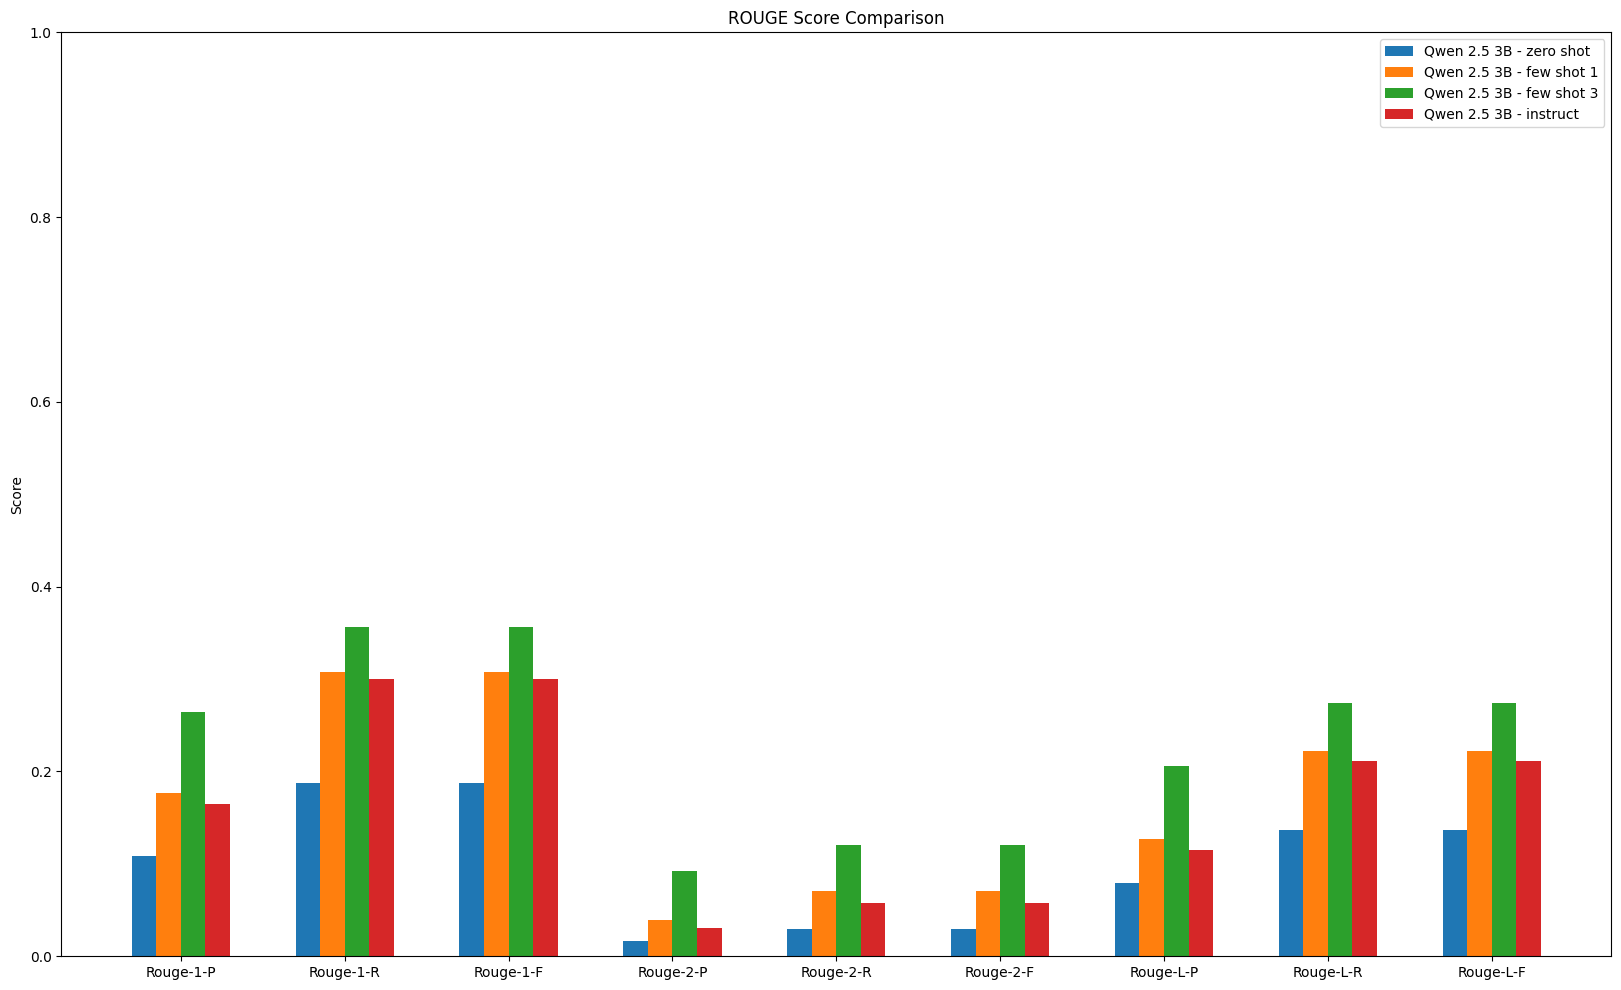

In [67]:
plot_data([data_better, data_better_1, data_better_3, data_instruct_25],models=['Qwen 2.5 3B - zero shot', 'Qwen 2.5 3B - few shot 1',  'Qwen 2.5 3B - few shot 3', 'Qwen 2.5 3B - instruct'],width = 0.15, size = 20)